# はじめの一歩

In [1]:
import torch

In [132]:
dtype = torch.float

use_gpu = False

if use_gpu:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

想定するニューラルネットワークは 100 次元の実数値 $x \in \mathbb{R}^{100}$ を入力にとり、1次元の実数予測値 $\hat{y} \in \mathbb{R}$ を返すようなものです。

$$
z = W_1^T x + b_1\\
h = {\rm relu}(z) \\
\hat{y} = W_2^T h + b_2
$$

ここで $W_1 \in \mathbb{R}^{100 \times 1000}, W_2 \in \mathbb{R}^{10 \times 100}$ はそれぞれネットワークの重みを指します。
また $b_1 \in \mathbb{R}^{1000}, b_2 \in \mathbb{R}^{10}$ はバイアスパラメータです。

In [133]:
batch_size = 100
input_dim = 1000
hidden_dim = 100
outpu_dim = 10

In [146]:
variable_types = {
    "device": device,
    "dtype": dtype
}

入力データと正解ラベルをガウスノイズを用いてランダムに作成します。

In [135]:
x = torch.randn(batch_size, input_dim, **variable_types)
y = torch.randn(batch_size, outpu_dim, **variable_types)

In [136]:
# 重みの初期値はランダムに設定
w1 = torch.randn(input_dim, hidden_dim, **variable_types)
w2 = torch.randn(hidden_dim, outpu_dim, **variable_types)

In [137]:
w1.data.var(), w1.min()

(tensor(0.9932), tensor(-4.3773))

In [138]:
lr = 2e-6

## 手計算で backward

重みに対する `backward` をチェーンルールを用いて計算し、それを随時適用することで重みを更新する、というパワープレイ。

ちなみに今回のモデルに対する勾配は以下のようになる、はず。

$$
f(y, \hat{y}) = \| y - \hat{y} \|^2
$$

$$
\begin{align}
\frac{\partial f}{\partial W_2} &= - 2 (y - \hat{y}) h \\
\frac{\partial f}{\partial W_1} &= (- 2 (y - \hat{y}) W_1 {\rm diag}(H_0(h)) x )^T \\
&= -2 x^T (y - \hat{y}) W_1 {\rm diag}(H_0(h))
\end{align}
$$

ここで $H_0$ はヘヴィサイドの階段関数

In [139]:
%%time

epochs = 1000
losses = []
for i in range(epochs):
    z = x.mm(w1)

    # relu activetion
    a = z.clamp(min=0)
    pred = a.mm(w2)

    loss = ((pred - y) ** 2.).sum()
    losses.append(loss.item())

    grad_pred = 2 * (pred - y)

    grad_pred.shape

    grad_w2 = a.t().mm(grad_pred)

    grad_w2.shape

    grad_a = grad_pred.mm(w2.t())

    grad_a[z < 0] = 0

    grad_w1 = x.t().mm(grad_a)

    grad_w1.shape

    w1 -= lr * grad_w1 
    w2 -= lr * grad_w2
    
    if i % 200 == 0:
        lr *= .5

CPU times: user 2.09 s, sys: 8.17 ms, total: 2.1 s
Wall time: 525 ms


In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

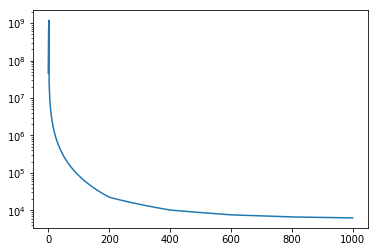

In [127]:
plt.plot(losses)
plt.yscale("log")

## Autograd を使う

先の例では自分で勾配を計算していた。
torch は自動微分が定義されているのでこれを使うとb `backword` の部分を計算グラフから自動で計算してくれる。

自動微分を用いるには `require_grad=True` にすればOK

In [147]:
variable_types["requires_grad"] = True

In [177]:
w1 = torch.randn(input_dim, hidden_dim, **variable_types)
w2 = torch.randn(hidden_dim, outpu_dim, **variable_types)

In [178]:
lr = 1e-6

In [179]:
losses = []
for epoch in range(epochs):
    
    # forward (順伝搬) の計算を定義するだけでOK
    pred = x.mm(w1).clamp(min=0).mm(w2)
    
    loss = (y - pred).pow(2).sum()
    
    loss.backward()
    losses.append(loss.item())

    # 以下で重みを update するがこの時の変更は autograd に追跡されたくない。
    # `with torch.no_grad()` の部分では追跡を行わないようになる。
    # 他の方法としては tensor の値を直接変更するという方法がある
    # ex). w1.data -= lr* w1.grad.data
    # しかしこの方法だと履歴を追跡できなくなる
    with torch.no_grad():
        w1 -= lr * w1.grad
        w2 -= lr * w2.grad
        
        # 破壊的に勾配の値を 0 にする
        w1.grad.zero_()
        w2.grad.zero_()

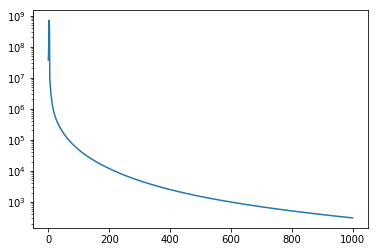

In [180]:
plt.plot(losses, "-")
plt.yscale("log")

## torch.nn を使う

In [199]:
class SimpleNNModel(torch.nn.Module):
    """
    二層のニューラルネットワークモデル"""
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        
        self.dense1 = torch.nn.Linear(input_dim, hidden_dim)
        self.dense2 = torch.nn.Linear(hidden_dim, outpu_dim)
        
    def forward(self, x):
        """
        順伝搬の計算を行って予測値を返す"""
        
        h = self.dense1(x)
        
        # equal to relu activation
        h = h.clamp(min=0)
        
        pred = self.dense2(h)
        return pred

In [200]:
clf = SimpleNNModel(input_dim, outpu_dim, hidden_dim)

In [201]:
clf

SimpleNNModel(
  (dense1): Linear(in_features=1000, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=10, bias=True)
)

In [202]:
# `criterion`: 予測値と正解ラベルとの差分を計算するオブジェクト
# `size_averaging` を `False` にすると, 与えられたバッチ n それぞれの rmse を合計した loss を返す。
# デフォルトでは `True` (すなわちバッチそれぞれの値を配列として返す)
criterion = torch.nn.MSELoss(size_average=False)

# 勾配の初期化, 重みの update などの方法(アルゴリズム) が torch.optima にいろいろ定義されている
# 今回は単純な stochastic gradient descent を使う
optimizer = torch.optim.SGD(clf.parameters(), lr=1e-5, momentum=.8, weight_decay=1e-8, nesterov=True)

In [203]:
losses = []
for epoch in range(epochs):
    pred = clf.forward(x)
    loss = criterion(pred, y)
    losses.append(loss.item())
    # 登録されたパラメータの勾配を 0 にする
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

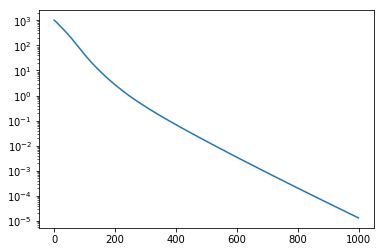

In [204]:
plt.plot(losses)
plt.yscale("log")